# 1 Introduction

This Jupyter Notebook gives a quick tutorial on how to use my S4 Python Helper files, ```SpectralScan.py``` and ```EricFitter.py```.    

I use ```S4``` in the context of simulating photonic crystal slabs (PCS).  I created ```SpectralScan.py``` so that I could easily and efficiently simulate the transmission/reflection spectrum of an infinite-lattice PCS; it allows for me to run ```S4``` in a multi-threaded fashion.  This saves time because I can spread out the work over the many cores available in a modern CPU.

After the creation of the spectrum, I will often have to determine the peak wavelength $\lambda_0$ and linewidth  $\Gamma$ of the resonance.  This is where ```EricFitter.py``` comes in; it contains functions to normalize the data, crop the spectrum to the region of interest, and fits the resonance to a Fano (or Lorentzian) peak to determine $\lambda_0$ and  $\Gamma$.

# 2 Setup

Let's start by importing all the libraries we will need.  In addition to ```S4```, which was compiled from source with instructions from GitHub user ```phoebe-p```, we will also need ```numpy``` and ```matplotlib``` for some linear algebra and visualization functions, respectively.  

In [6]:
# let's just delete all the variables in this workspace:
%reset 

import S4 #S4 library
# built using source and instructions from:
# https://github.com/phoebe-p/S4


import time # built-in Python library, used for measuring the time it takes to run the simulation

#numpy and matplotlib
import numpy as np
from matplotlib.pyplot import figure, plot
import matplotlib.pyplot as plt

#tell Jupyter Notebook to output only vector graphics files
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

#import my python helper files
import Dependencies.EricFitter as EF
import Dependencies.SpectralScan as SpecScan # change this back!

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## 2.1 Creating the ```S4``` simulation object


![A photonic crystal slab (PCS)](OL_paper.png)

The above image was taken from Figure 1 of [1].  It illustrates the PCS that I want to simulate, with a slight modification. 

The layer structure consists of :
- a semi-infinite layer of water, 
- a layer of silicon nitride, with thickness $t_{SiN} = 0.25 \ \mu$m,
- a layer of fused silica, with thickness $t_{SiO_2} = 2.36 \ \mu$m, and finally
- a thick 330$\ \mu$m-layer of silicon, which for all intents and purposes can be considered to by semi-infinite


The PCS structure is a simple square-lattice with circular nanoholes patterned into the silicon nitride layer:
- lattice constant $a = 1.00\ \mathrm{\mu{m}}$
- nanohole radius $r = 0.100\ \mathrm{\mu{m}}$


I'm now going to construct the function that creates the ```S4``` simulation object using these parameters.  Note that all length parameters are given in __microns__, so beware.  


[1] E. Y. Zhu, C. Rewcastle, R. Gad, L. Qian, and O. Levi,  Opt. Lett. __44__, 2609-2612 (2019).



In [24]:

#returns S, an S4 simulation object

def DefineSimulation():

    tSiN = 0.25 # microns
    tSiO2 = 2.36 # microns
    a = 1.00    # microns
    r = 0.1     # microns 
    
    # define the square lattice:
    S = S4.New( Lattice=((a,0),(0,a)) , NumBasis=30)
    
    # Define Materials to be used:
    S.SetMaterial(Name = 'Water', Epsilon = 1.318**2 + 0j) 
    S.SetMaterial(Name = 'SiN', Epsilon = 2.00**2 + 0j)   # stoichiometric Si3N4
    S.SetMaterial(Name = 'SiO', Epsilon = 1.446**2 + 0j)  # thermal SiO2, fused silica
    S.SetMaterial(Name = 'Si',  Epsilon = 3.476**2 + 0j)  # Silicon 

    # Add Layers
    #           laynername, thickness, material
    S.AddLayer('layer0',    0      ,  'Water')  # a thickness of 0 means it's a semi-infinite layer
    S.AddLayer('layer1',    tSiN   ,  'SiN')
    S.AddLayer('layer2',    tSiO2  ,  'SiO')
    S.AddLayer('layer3',    0      ,  'Si')

    # Add Patterning   
    # pattern a nanohole of radius r into the center of the unit cell
    # do the patterning in 'layer1' (SiN) and fill the nanohole with the material 'Water'
    S.SetRegionCircle('layer1', 'Water', Center = (0,0), Radius=r)  
           
    # excite with normal incidence 
    # s-polarization means electric field is normal to the plane of incidence
    # light in the form of a planewave is launched from the top-layer (layer0)
    S.SetExcitationPlanewave( IncidenceAngles=(0,0), # normal incidence
                             sAmplitude  = 1, pAmplitude  = 0, 
                             Order = 0)
    return S





## 2.2 Running the Simulation

We can now instantiate the ```S4``` simulation object, and obtain a spectrum for the ```TE``` resonance, which I know from experiment to reside at $\sim$ 1580 nm (1.58 $\mu$m).  

In [20]:
S = DefineSimulation() # instantiate the S4 simulation object

#define the range of wavelengths I want to scan over, along with the resolution
# note that these values are also in microns
startwl, stopwl, res  = (1580e-3, 1590e-3, 0.05e-3)

# let's launch light from layer0, the water layer
whichlayer = 'layer0'

# how many threads should I divide over?  
# choose between N/2 to N, where N is the number of total cores 
# (not threads) in system
NumThreads = 3

tic = time.time()  
wls, Spectrum = SpecScan.MultiThreadedSpectralScan(S, startwl, stopwl, res, whichlayer, NumThreads)
print("Creating dataset took {:.3f}s".format(time.time() - tic))      


  

Creating dataset took 4.778s


Let's now plot out this spectrum, using ```matplotlib```.

(array([1578., 1580., 1582., 1584., 1586., 1588., 1590., 1592.]),
 <a list of 8 Text major ticklabel objects>)

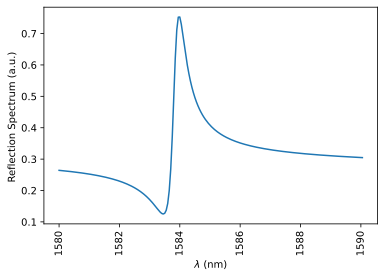

In [23]:
fig, ax = plt.subplots() 

ax.plot(wls*1e3,np.abs(Spectrum))  
plt.xlabel('$\lambda$ (nm)')
plt.ylabel('Reflection Spectrum (a.u.) ')
plt.xticks(rotation='vertical')

## 2.2 Analyzing the Spectrum 

Now that we have generated the spectrum let's analyze it using the functions from ```EricFitter.py```.  

The first function we will look at is ```FindProperRange()```, which takes the spectrum and isolates the peak as a region of interest (ROI); it does this by looking for the inflection points around the peak.  

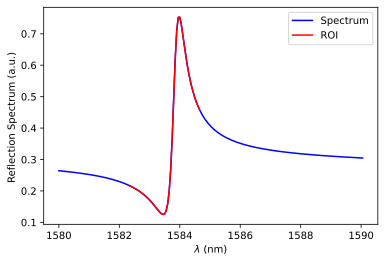

In [45]:
from matplotlib.pyplot import legend

#for fun, let's put the data into a dictionary
Data_struct = {"wl": wls, 'spectrum': np.abs(Spectrum)}

xdata = np.array(Data_struct['wl'])
ydata = np.array(Data_struct['spectrum'])

# we need to remove some duplicate wavelengths
xdata, index = EF.RemoveConsecutiveClones(xdata)
ydata = ydata[index]

#the following function takes the whole spectrum and provides us with the 
# index range where the optical resonance peak is likely to be
indexLeft, indexRite = EF.FindProperRange(xdata, ydata)

xdata_trunc = xdata[indexLeft:indexRite]
ydata_trunc = ydata[indexLeft:indexRite]

fig2, ax2 = plt.subplots()
ax2.plot(xdata*1e3, ydata, 'b',
    xdata_trunc*1e3, ydata_trunc, 'r')
plt.xlabel('$\lambda$ (nm)')
plt.ylabel('Reflection Spectrum (a.u.) ')
legend(['Spectrum', 'ROI'])

Finally, let's take this ROI and fit it to a Fano peak so that we can determine the optical resonance's peak wavelength $\lambda_0$ and linewidth $\Gamma$ (or quality factor Q).  

Peak at 1583.84 nm, linewidth = 0.50 nm
Q = 3.155e+03


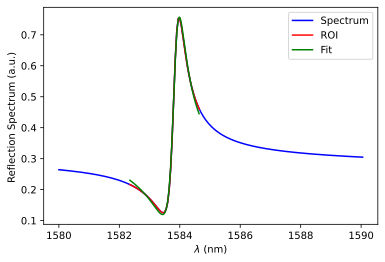

In [44]:

#let's find where the reflection peak is:
indexPeak = np.argmax(ydata_trunc)

# we need to provide a guess for the peak wavelength of the optical resonance
# our guess is simply  xdata_trunc[indexPeak]
lambda0, Linewidth, q, xth, yth, Amplitude = EF.FitFano(xdata_trunc, ydata_trunc, xdata_trunc[indexPeak])

#FitFano() spits out the peak wavelength lambda0, linewidth Linewidth, 
# Fano asymmetry factor 'q', the curve of best fit (xth,yth), as well as the Amplitude of the peak resonance

fig3, ax3 = plt.subplots()

ax3.plot(xdata*1e3, ydata, 'b',
    xdata_trunc*1e3, ydata_trunc, 'r', 
        xth*1e3, yth, 'g', )
plt.xlabel('$\lambda$ (nm)')
plt.ylabel('Reflection Spectrum (a.u.) ')
legend(['Spectrum', 'ROI', 'Fit'])

print('Peak at %2.2f nm, linewidth = %2.2f nm' %(lambda0*1e3, Linewidth*1e3))
print('Q = %2.3e'%(lambda0/Linewidth))

# 3 Wrapup

I hope you have found this tutorial useful.  The helper modules ```SpectralScan.py``` and ```EricFitter.py``` take advantage of an already powerful tool (```S4```) and adds greater functionality to it by allowing us to:

1) calculate the spectra of various periodic devices in a multi-threaded fashion, and 

2) perform fitting on the calculated spectra to provide salient information about a particular resonance.  